# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


In [2]:
import sys
sys.executable

'/home/cipher000/anaconda3/envs/tensorflow1.0/bin/python'

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

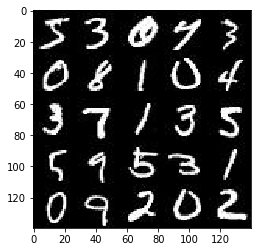

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

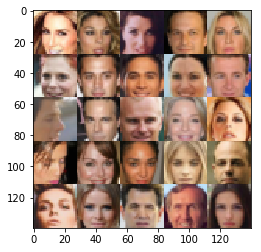

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    r_input = tf.placeholder(tf.float32,(None, image_width,image_height,image_channels)) # rank 4
    z_input = tf.placeholder(tf.float32,(None, z_dim)) # rank 2
    learning_rate = tf.placeholder(tf.float32,name="learn_rate") # rank 0
    return (r_input, z_input, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False,alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # modify code; from project dcgan-svhn
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3 
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True,alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # modify code; from project dcgan-svhn
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x5 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim,alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    # modify code; from project dcgan-svhn    
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # modify code; from project dcgan-svhn    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()


### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
import matplotlib.pyplot as plt

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # modify code; from project dcgan-svhn        
#     saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0
    print_every = 10
    show_every = 100
    
    # Build model
    r_input, z_input, lr = model_inputs(data_shape[1],data_shape[2], len(data_image_mode), z_dim)
    d_loss, g_loss = model_loss(r_input, z_input, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model

                
                # modify code; from project dcgan-svhn        
                steps += 1
                batch_images = batch_images*2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={r_input: batch_images, z_input: batch_z,lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_input: batch_z, r_input: batch_images,lr:learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_input: batch_z, r_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})                 
                    
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(z_input, data_shape[3], is_train=False),
                                   feed_dict={z_input: sample_z})
                    samples.append(gen_samples)
                    _ = show_generator_output(sess, 5, z_input, data_shape[3], data_image_mode)
                    plt.show()

#         saver.save(sess, './checkpoints/generator.ckpt')

#     with open('samples.pkl', 'wb') as f:
#         pkl.dump(samples, f)
    
    return losses, samples
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8363... Generator Loss: 1.2981
Epoch 1/2... Discriminator Loss: 1.0416... Generator Loss: 1.0888
Epoch 1/2... Discriminator Loss: 1.0245... Generator Loss: 2.4334
Epoch 1/2... Discriminator Loss: 1.1591... Generator Loss: 1.8194
Epoch 1/2... Discriminator Loss: 1.5189... Generator Loss: 0.4445
Epoch 1/2... Discriminator Loss: 1.1808... Generator Loss: 1.3402
Epoch 1/2... Discriminator Loss: 1.1225... Generator Loss: 0.9855
Epoch 1/2... Discriminator Loss: 1.2736... Generator Loss: 0.7107
Epoch 1/2... Discriminator Loss: 1.2216... Generator Loss: 0.9298
Epoch 1/2... Discriminator Loss: 1.1997... Generator Loss: 0.7871


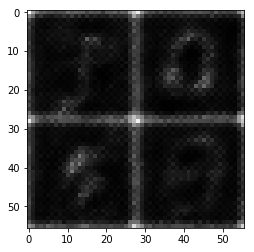

Epoch 1/2... Discriminator Loss: 1.1056... Generator Loss: 1.2430
Epoch 1/2... Discriminator Loss: 1.2889... Generator Loss: 0.5927
Epoch 1/2... Discriminator Loss: 1.1000... Generator Loss: 0.8980
Epoch 1/2... Discriminator Loss: 1.1782... Generator Loss: 1.8361
Epoch 1/2... Discriminator Loss: 1.1690... Generator Loss: 1.9138
Epoch 1/2... Discriminator Loss: 1.1864... Generator Loss: 1.6708
Epoch 1/2... Discriminator Loss: 0.9869... Generator Loss: 1.7745
Epoch 1/2... Discriminator Loss: 1.1654... Generator Loss: 0.6907
Epoch 1/2... Discriminator Loss: 0.9074... Generator Loss: 1.2896
Epoch 1/2... Discriminator Loss: 1.1280... Generator Loss: 0.7161


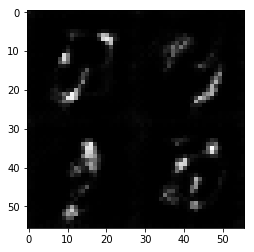

Epoch 1/2... Discriminator Loss: 0.9311... Generator Loss: 0.9984
Epoch 1/2... Discriminator Loss: 1.3686... Generator Loss: 0.5142
Epoch 1/2... Discriminator Loss: 0.9208... Generator Loss: 0.9680
Epoch 1/2... Discriminator Loss: 0.9230... Generator Loss: 0.9767
Epoch 1/2... Discriminator Loss: 0.8521... Generator Loss: 2.0453
Epoch 1/2... Discriminator Loss: 0.7829... Generator Loss: 2.3068
Epoch 1/2... Discriminator Loss: 0.8493... Generator Loss: 1.2501
Epoch 1/2... Discriminator Loss: 0.7992... Generator Loss: 1.2457
Epoch 1/2... Discriminator Loss: 0.9993... Generator Loss: 2.0877
Epoch 1/2... Discriminator Loss: 0.7375... Generator Loss: 1.5138


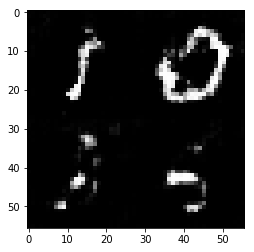

Epoch 1/2... Discriminator Loss: 1.0310... Generator Loss: 1.8432
Epoch 1/2... Discriminator Loss: 0.7883... Generator Loss: 1.9462
Epoch 1/2... Discriminator Loss: 1.1203... Generator Loss: 0.7341
Epoch 1/2... Discriminator Loss: 1.1487... Generator Loss: 0.7469
Epoch 1/2... Discriminator Loss: 1.2473... Generator Loss: 2.5662
Epoch 1/2... Discriminator Loss: 1.0363... Generator Loss: 1.5965
Epoch 1/2... Discriminator Loss: 1.6289... Generator Loss: 2.9261
Epoch 1/2... Discriminator Loss: 1.0794... Generator Loss: 0.7807
Epoch 1/2... Discriminator Loss: 1.3198... Generator Loss: 0.6063
Epoch 1/2... Discriminator Loss: 0.9671... Generator Loss: 1.4532


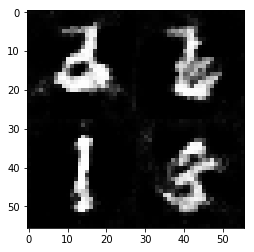

Epoch 1/2... Discriminator Loss: 1.2778... Generator Loss: 0.5752
Epoch 1/2... Discriminator Loss: 0.9148... Generator Loss: 1.7017
Epoch 1/2... Discriminator Loss: 1.3163... Generator Loss: 2.3978
Epoch 1/2... Discriminator Loss: 0.9960... Generator Loss: 1.0561
Epoch 1/2... Discriminator Loss: 0.8831... Generator Loss: 1.2137
Epoch 1/2... Discriminator Loss: 1.0420... Generator Loss: 0.9129
Epoch 2/2... Discriminator Loss: 0.9721... Generator Loss: 1.2172
Epoch 2/2... Discriminator Loss: 1.0779... Generator Loss: 1.7495
Epoch 2/2... Discriminator Loss: 1.1817... Generator Loss: 0.6961
Epoch 2/2... Discriminator Loss: 1.0606... Generator Loss: 0.7862


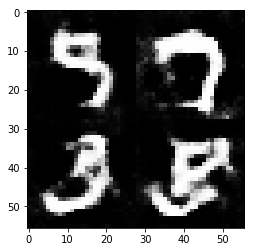

Epoch 2/2... Discriminator Loss: 0.9792... Generator Loss: 0.9514
Epoch 2/2... Discriminator Loss: 1.1372... Generator Loss: 0.7674
Epoch 2/2... Discriminator Loss: 1.0566... Generator Loss: 1.8396
Epoch 2/2... Discriminator Loss: 0.9540... Generator Loss: 1.0611
Epoch 2/2... Discriminator Loss: 0.9422... Generator Loss: 1.2349
Epoch 2/2... Discriminator Loss: 1.5274... Generator Loss: 0.4744
Epoch 2/2... Discriminator Loss: 1.0418... Generator Loss: 0.8982
Epoch 2/2... Discriminator Loss: 0.9931... Generator Loss: 1.7361
Epoch 2/2... Discriminator Loss: 0.9662... Generator Loss: 1.2097
Epoch 2/2... Discriminator Loss: 1.0298... Generator Loss: 1.2038


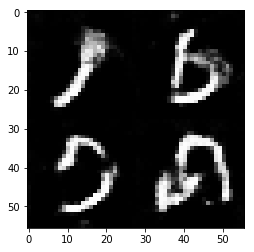

Epoch 2/2... Discriminator Loss: 0.9353... Generator Loss: 1.3051
Epoch 2/2... Discriminator Loss: 0.9861... Generator Loss: 1.0100
Epoch 2/2... Discriminator Loss: 0.9656... Generator Loss: 1.4700
Epoch 2/2... Discriminator Loss: 0.9532... Generator Loss: 1.0606
Epoch 2/2... Discriminator Loss: 0.8456... Generator Loss: 1.3403
Epoch 2/2... Discriminator Loss: 1.2245... Generator Loss: 0.6228
Epoch 2/2... Discriminator Loss: 0.9770... Generator Loss: 1.0252
Epoch 2/2... Discriminator Loss: 0.9098... Generator Loss: 1.1908
Epoch 2/2... Discriminator Loss: 0.9259... Generator Loss: 1.2439
Epoch 2/2... Discriminator Loss: 0.8764... Generator Loss: 1.2628


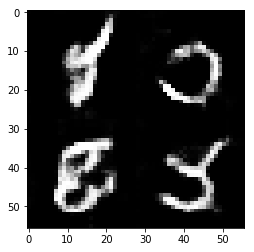

Epoch 2/2... Discriminator Loss: 0.8290... Generator Loss: 1.3351
Epoch 2/2... Discriminator Loss: 1.1313... Generator Loss: 2.0582
Epoch 2/2... Discriminator Loss: 1.0119... Generator Loss: 0.8759
Epoch 2/2... Discriminator Loss: 0.8748... Generator Loss: 1.7007
Epoch 2/2... Discriminator Loss: 1.0306... Generator Loss: 0.8449
Epoch 2/2... Discriminator Loss: 0.9494... Generator Loss: 2.3582
Epoch 2/2... Discriminator Loss: 0.9021... Generator Loss: 1.7876
Epoch 2/2... Discriminator Loss: 0.9647... Generator Loss: 1.1878
Epoch 2/2... Discriminator Loss: 0.9040... Generator Loss: 1.0580
Epoch 2/2... Discriminator Loss: 0.9232... Generator Loss: 1.2756


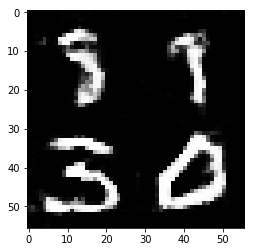

Epoch 2/2... Discriminator Loss: 0.8477... Generator Loss: 1.1320
Epoch 2/2... Discriminator Loss: 1.3365... Generator Loss: 2.5530
Epoch 2/2... Discriminator Loss: 0.9482... Generator Loss: 1.2165
Epoch 2/2... Discriminator Loss: 0.8661... Generator Loss: 1.2522
Epoch 2/2... Discriminator Loss: 0.8885... Generator Loss: 1.5310
Epoch 2/2... Discriminator Loss: 0.8250... Generator Loss: 1.1541
Epoch 2/2... Discriminator Loss: 1.6564... Generator Loss: 0.4412
Epoch 2/2... Discriminator Loss: 0.8596... Generator Loss: 1.1580
Epoch 2/2... Discriminator Loss: 0.9873... Generator Loss: 0.8755
Epoch 2/2... Discriminator Loss: 0.8150... Generator Loss: 1.3473


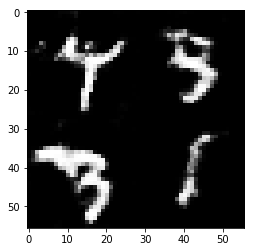

Epoch 2/2... Discriminator Loss: 0.8091... Generator Loss: 1.3914
Epoch 2/2... Discriminator Loss: 0.8903... Generator Loss: 2.1458
Epoch 2/2... Discriminator Loss: 0.6539... Generator Loss: 1.7450


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7027... Generator Loss: 1.7068
Epoch 1/1... Discriminator Loss: 0.5220... Generator Loss: 2.3815
Epoch 1/1... Discriminator Loss: 0.5757... Generator Loss: 1.9185
Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 4.1734
Epoch 1/1... Discriminator Loss: 0.7697... Generator Loss: 1.8343
Epoch 1/1... Discriminator Loss: 0.6215... Generator Loss: 2.5621
Epoch 1/1... Discriminator Loss: 0.7749... Generator Loss: 1.7120
Epoch 1/1... Discriminator Loss: 0.5715... Generator Loss: 3.0409
Epoch 1/1... Discriminator Loss: 0.7510... Generator Loss: 1.6937
Epoch 1/1... Discriminator Loss: 0.8807... Generator Loss: 1.1048


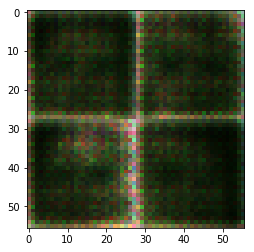

Epoch 1/1... Discriminator Loss: 0.8251... Generator Loss: 4.7894
Epoch 1/1... Discriminator Loss: 0.6840... Generator Loss: 1.6212
Epoch 1/1... Discriminator Loss: 0.5222... Generator Loss: 2.3034
Epoch 1/1... Discriminator Loss: 0.6196... Generator Loss: 2.1337
Epoch 1/1... Discriminator Loss: 0.6485... Generator Loss: 1.6911
Epoch 1/1... Discriminator Loss: 0.6739... Generator Loss: 1.7444
Epoch 1/1... Discriminator Loss: 0.7725... Generator Loss: 1.2932
Epoch 1/1... Discriminator Loss: 0.7950... Generator Loss: 1.4519
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 3.2176
Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 0.7111


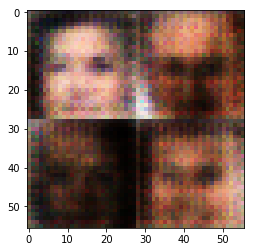

Epoch 1/1... Discriminator Loss: 1.0318... Generator Loss: 0.8784
Epoch 1/1... Discriminator Loss: 0.6672... Generator Loss: 1.5846
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 0.6304... Generator Loss: 1.6319
Epoch 1/1... Discriminator Loss: 0.5422... Generator Loss: 2.5088
Epoch 1/1... Discriminator Loss: 0.7239... Generator Loss: 1.4574
Epoch 1/1... Discriminator Loss: 0.7002... Generator Loss: 1.7151
Epoch 1/1... Discriminator Loss: 0.8650... Generator Loss: 2.7262
Epoch 1/1... Discriminator Loss: 0.9197... Generator Loss: 1.8157
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.4949


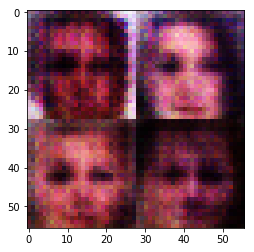

Epoch 1/1... Discriminator Loss: 0.6597... Generator Loss: 2.5341
Epoch 1/1... Discriminator Loss: 0.7648... Generator Loss: 1.5635
Epoch 1/1... Discriminator Loss: 0.5758... Generator Loss: 2.6472
Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.5300
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.5289
Epoch 1/1... Discriminator Loss: 0.8440... Generator Loss: 2.4631
Epoch 1/1... Discriminator Loss: 0.6093... Generator Loss: 2.0004
Epoch 1/1... Discriminator Loss: 1.2023... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 0.8858... Generator Loss: 1.2312
Epoch 1/1... Discriminator Loss: 0.6756... Generator Loss: 1.7544


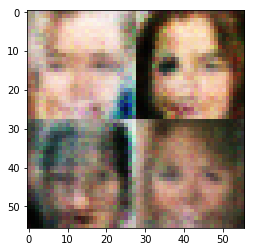

Epoch 1/1... Discriminator Loss: 0.7209... Generator Loss: 1.3783
Epoch 1/1... Discriminator Loss: 2.0296... Generator Loss: 5.5067
Epoch 1/1... Discriminator Loss: 0.5544... Generator Loss: 3.1194
Epoch 1/1... Discriminator Loss: 1.7940... Generator Loss: 0.3310
Epoch 1/1... Discriminator Loss: 1.1835... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 0.6711... Generator Loss: 1.8000
Epoch 1/1... Discriminator Loss: 0.7763... Generator Loss: 1.8450
Epoch 1/1... Discriminator Loss: 0.9155... Generator Loss: 7.4606
Epoch 1/1... Discriminator Loss: 0.8361... Generator Loss: 1.0969
Epoch 1/1... Discriminator Loss: 0.5678... Generator Loss: 3.0555


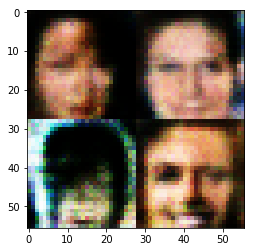

Epoch 1/1... Discriminator Loss: 0.5095... Generator Loss: 2.5290
Epoch 1/1... Discriminator Loss: 0.8684... Generator Loss: 1.0391
Epoch 1/1... Discriminator Loss: 0.5062... Generator Loss: 2.2745
Epoch 1/1... Discriminator Loss: 0.6120... Generator Loss: 1.8656
Epoch 1/1... Discriminator Loss: 1.1002... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 0.6984... Generator Loss: 1.4211
Epoch 1/1... Discriminator Loss: 1.7426... Generator Loss: 0.3202
Epoch 1/1... Discriminator Loss: 0.3964... Generator Loss: 4.0188
Epoch 1/1... Discriminator Loss: 0.8875... Generator Loss: 0.9419
Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 0.6753


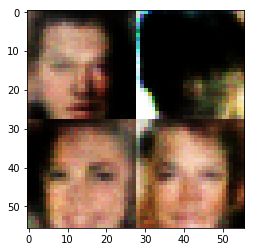

Epoch 1/1... Discriminator Loss: 0.4287... Generator Loss: 2.9634
Epoch 1/1... Discriminator Loss: 0.8344... Generator Loss: 3.4521
Epoch 1/1... Discriminator Loss: 0.7999... Generator Loss: 2.9006
Epoch 1/1... Discriminator Loss: 0.4552... Generator Loss: 3.2471
Epoch 1/1... Discriminator Loss: 0.9158... Generator Loss: 0.9377
Epoch 1/1... Discriminator Loss: 1.0985... Generator Loss: 2.1078
Epoch 1/1... Discriminator Loss: 0.6466... Generator Loss: 1.9783
Epoch 1/1... Discriminator Loss: 0.5308... Generator Loss: 4.1532
Epoch 1/1... Discriminator Loss: 0.5873... Generator Loss: 2.6239
Epoch 1/1... Discriminator Loss: 0.7049... Generator Loss: 3.7560


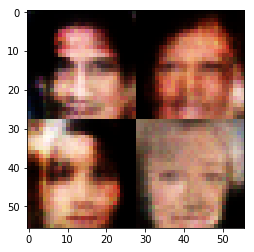

Epoch 1/1... Discriminator Loss: 0.9827... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 0.8376... Generator Loss: 1.1526
Epoch 1/1... Discriminator Loss: 0.6832... Generator Loss: 1.3803
Epoch 1/1... Discriminator Loss: 0.5878... Generator Loss: 2.1057
Epoch 1/1... Discriminator Loss: 0.5408... Generator Loss: 5.3446
Epoch 1/1... Discriminator Loss: 0.5522... Generator Loss: 1.9743
Epoch 1/1... Discriminator Loss: 0.8953... Generator Loss: 0.9760
Epoch 1/1... Discriminator Loss: 0.4758... Generator Loss: 3.9882
Epoch 1/1... Discriminator Loss: 0.7484... Generator Loss: 1.3178
Epoch 1/1... Discriminator Loss: 0.5453... Generator Loss: 2.6482


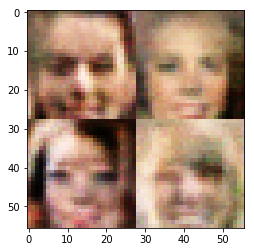

Epoch 1/1... Discriminator Loss: 0.3954... Generator Loss: 3.9525
Epoch 1/1... Discriminator Loss: 0.7000... Generator Loss: 1.3914
Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 2.8201
Epoch 1/1... Discriminator Loss: 0.4532... Generator Loss: 2.6674
Epoch 1/1... Discriminator Loss: 0.8631... Generator Loss: 1.0738
Epoch 1/1... Discriminator Loss: 0.7131... Generator Loss: 1.3301
Epoch 1/1... Discriminator Loss: 0.3916... Generator Loss: 4.1445
Epoch 1/1... Discriminator Loss: 0.8149... Generator Loss: 4.2416
Epoch 1/1... Discriminator Loss: 0.4411... Generator Loss: 3.1145
Epoch 1/1... Discriminator Loss: 0.4527... Generator Loss: 2.5914


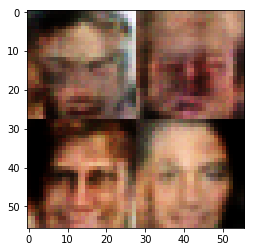

Epoch 1/1... Discriminator Loss: 0.3940... Generator Loss: 3.5168
Epoch 1/1... Discriminator Loss: 0.6446... Generator Loss: 1.5208
Epoch 1/1... Discriminator Loss: 0.5442... Generator Loss: 1.8837
Epoch 1/1... Discriminator Loss: 0.4309... Generator Loss: 4.7878
Epoch 1/1... Discriminator Loss: 0.4341... Generator Loss: 2.6834
Epoch 1/1... Discriminator Loss: 0.5528... Generator Loss: 1.8905
Epoch 1/1... Discriminator Loss: 0.4678... Generator Loss: 2.4574
Epoch 1/1... Discriminator Loss: 0.9764... Generator Loss: 1.5314
Epoch 1/1... Discriminator Loss: 0.4756... Generator Loss: 2.4863
Epoch 1/1... Discriminator Loss: 0.4366... Generator Loss: 2.8942


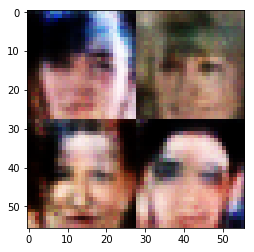

Epoch 1/1... Discriminator Loss: 0.3930... Generator Loss: 3.5299
Epoch 1/1... Discriminator Loss: 0.4808... Generator Loss: 2.3742
Epoch 1/1... Discriminator Loss: 0.5605... Generator Loss: 2.0217
Epoch 1/1... Discriminator Loss: 0.4078... Generator Loss: 3.5365
Epoch 1/1... Discriminator Loss: 0.4443... Generator Loss: 2.7519
Epoch 1/1... Discriminator Loss: 0.6449... Generator Loss: 1.5451
Epoch 1/1... Discriminator Loss: 0.9663... Generator Loss: 0.9046
Epoch 1/1... Discriminator Loss: 0.4324... Generator Loss: 2.8377
Epoch 1/1... Discriminator Loss: 0.4840... Generator Loss: 2.3524
Epoch 1/1... Discriminator Loss: 0.8951... Generator Loss: 3.8054


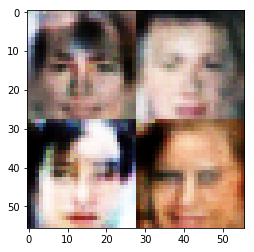

Epoch 1/1... Discriminator Loss: 0.3887... Generator Loss: 3.6722
Epoch 1/1... Discriminator Loss: 0.5463... Generator Loss: 1.8458
Epoch 1/1... Discriminator Loss: 0.4577... Generator Loss: 2.7500
Epoch 1/1... Discriminator Loss: 0.5492... Generator Loss: 3.1895
Epoch 1/1... Discriminator Loss: 0.4253... Generator Loss: 4.4815
Epoch 1/1... Discriminator Loss: 0.4882... Generator Loss: 2.2062
Epoch 1/1... Discriminator Loss: 0.4864... Generator Loss: 2.2608
Epoch 1/1... Discriminator Loss: 0.4114... Generator Loss: 3.0860
Epoch 1/1... Discriminator Loss: 1.5915... Generator Loss: 0.4394
Epoch 1/1... Discriminator Loss: 0.5770... Generator Loss: 4.2894


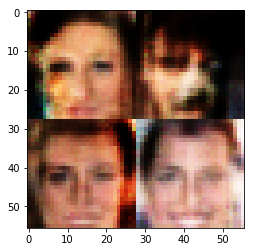

Epoch 1/1... Discriminator Loss: 0.5912... Generator Loss: 3.7071
Epoch 1/1... Discriminator Loss: 1.0654... Generator Loss: 3.7176
Epoch 1/1... Discriminator Loss: 0.6850... Generator Loss: 3.7663
Epoch 1/1... Discriminator Loss: 0.4459... Generator Loss: 2.7059
Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 2.5711
Epoch 1/1... Discriminator Loss: 0.6841... Generator Loss: 1.7374
Epoch 1/1... Discriminator Loss: 0.4019... Generator Loss: 3.3329
Epoch 1/1... Discriminator Loss: 0.4704... Generator Loss: 2.3596
Epoch 1/1... Discriminator Loss: 0.4736... Generator Loss: 2.4274
Epoch 1/1... Discriminator Loss: 0.4769... Generator Loss: 2.3377


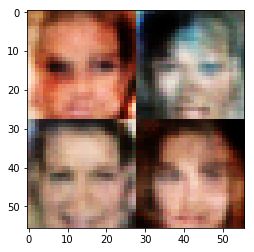

Epoch 1/1... Discriminator Loss: 0.5786... Generator Loss: 4.4103
Epoch 1/1... Discriminator Loss: 0.5425... Generator Loss: 1.9686
Epoch 1/1... Discriminator Loss: 0.7148... Generator Loss: 4.2516
Epoch 1/1... Discriminator Loss: 0.5912... Generator Loss: 3.3546
Epoch 1/1... Discriminator Loss: 0.4473... Generator Loss: 2.8587
Epoch 1/1... Discriminator Loss: 0.6022... Generator Loss: 1.9670
Epoch 1/1... Discriminator Loss: 0.4547... Generator Loss: 3.0541
Epoch 1/1... Discriminator Loss: 0.4311... Generator Loss: 2.8162
Epoch 1/1... Discriminator Loss: 0.6221... Generator Loss: 2.9466
Epoch 1/1... Discriminator Loss: 0.5467... Generator Loss: 2.7930


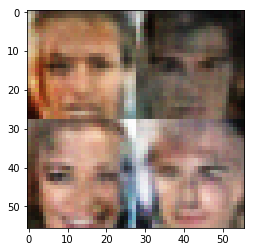

Epoch 1/1... Discriminator Loss: 0.5146... Generator Loss: 2.0756
Epoch 1/1... Discriminator Loss: 0.4768... Generator Loss: 2.4257
Epoch 1/1... Discriminator Loss: 0.3553... Generator Loss: 4.9892
Epoch 1/1... Discriminator Loss: 2.3541... Generator Loss: 2.6870
Epoch 1/1... Discriminator Loss: 0.7983... Generator Loss: 2.1242
Epoch 1/1... Discriminator Loss: 0.6653... Generator Loss: 1.4942
Epoch 1/1... Discriminator Loss: 0.5119... Generator Loss: 2.1428
Epoch 1/1... Discriminator Loss: 0.5340... Generator Loss: 1.9426
Epoch 1/1... Discriminator Loss: 0.5114... Generator Loss: 2.4231
Epoch 1/1... Discriminator Loss: 0.5058... Generator Loss: 2.4098


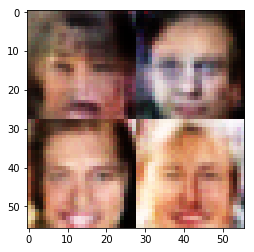

Epoch 1/1... Discriminator Loss: 0.4779... Generator Loss: 2.7793
Epoch 1/1... Discriminator Loss: 0.5934... Generator Loss: 3.6745
Epoch 1/1... Discriminator Loss: 0.4492... Generator Loss: 2.5816
Epoch 1/1... Discriminator Loss: 0.4153... Generator Loss: 3.3521
Epoch 1/1... Discriminator Loss: 0.6887... Generator Loss: 2.9695
Epoch 1/1... Discriminator Loss: 0.3793... Generator Loss: 4.1744
Epoch 1/1... Discriminator Loss: 0.5189... Generator Loss: 1.9857
Epoch 1/1... Discriminator Loss: 0.4718... Generator Loss: 2.3208


In [19]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.